In [67]:
from torchvision.datasets import DatasetFolder
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda:0')
# load the stft dataset from folder

path = "spectrograms"

# loader function for .npy files
def npy_loader(path):
    x = np.load(path)
    x = np.expand_dims(x, axis=0)
    return torch.tensor(x, dtype=torch.float32)

dataset = DatasetFolder(root=path, loader=npy_loader, extensions=[".npy"])

train_ratio = 0.8
val_ratio = 0.2
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    inputs, labels = zip(*batch)
    # inputs: list of tensors (1, freq, time)
    max_len = max(x.shape[-1] for x in inputs)
    padded = []
    for x in inputs:
        pad_len = max_len - x.shape[-1]
        if pad_len > 0:
            x = torch.nn.functional.pad(x, (0, pad_len))  # pad time dimension
        padded.append(x)
    return torch.stack(padded), torch.tensor(labels)
    
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,      
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,     
    num_workers=0,
    collate_fn=collate_fn
)
print("Finished loading the spectrograms")

Finished loading the spectrograms


In [82]:
print(len(train_loader))
print(len(val_loader))

187
47


In [97]:
import torch
import torch.nn as nn

class EmotionDetector(nn.Module): 
    def __init__(self, num_classes=6, n_fft=2048):
        super().__init__()

        self.convs = nn.ModuleList()

        layers = 3
        channels_out = 2
        channels_in = 1
        kernel_size = 3

        for i in range(layers):
            self.convs.append(
                nn.Sequential(
                    nn.Conv2d(channels_in, channels_out, kernel_size, padding="same"),
                    nn.BatchNorm2d(channels_out),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                )
            )
            channels_out = 2 * channels_out
            channels_in = 2 * channels_in
        
        '''
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, channels_out, 3, padding="same"),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            )
        channels_out = 2 * channels_out
        self.conv2 = nn.Sequential(
            nn.Conv2d(2, channels_out, 3, padding="same"),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            )
        channels_out = 2 * channels_out
        self.conv3 = nn.Sequential(
            nn.Conv2d(4, channels_out, 3, padding="same"),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            )
        '''
        self.freq_pool = nn.AdaptiveAvgPool2d((None,256))
        #self.lstm_input_size = 64 * 8
        #self.rnn = nn.GRU(self.lstm_input_size, 16, batch_first=True, bidirectional=True)
        #self.fc = nn.Linear(16*2, num_classes)
        self.fc1 = nn.Linear(262144,num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)
        '''
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        '''
        for conv in self.convs:
            x = conv(x)
        #x = self.freq_pool(x)
        x = self.freq_pool(x)
        
        x = x.flatten(start_dim=1)
        #x = x.permute(0, 3, 1, 2).contiguous().view(batch_size, x.size(3), -1)
        #x, _ = self.rnn(x)
        #x = x.mean(dim=1)
        x = self.fc1(x)
        return x


print("Memory-optimized model ready!")


Memory-optimized model ready!


 Using device  cuda


Epoch [1/10] Train Loss: 4.1297, Acc: 0.3098 Val Loss: 3.1618, Acc: 0.2451


Epoch [2/10] Train Loss: 1.7320, Acc: 0.3907 Val Loss: 1.8030, Acc: 0.2915


Epoch [3/10] Train Loss: 1.6273, Acc: 0.4279 Val Loss: 1.5775, Acc: 0.3956


Epoch [4/10] Train Loss: 1.4757, Acc: 0.4557 Val Loss: 1.5558, Acc: 0.4244


Epoch [5/10] Train Loss: 1.3840, Acc: 0.4851 Val Loss: 1.5432, Acc: 0.4157


Epoch [6/10] Train Loss: 1.3755, Acc: 0.4907 Val Loss: 1.5755, Acc: 0.4016


Epoch [7/10] Train Loss: 1.3675, Acc: 0.4907 Val Loss: 1.4912, Acc: 0.4218


Epoch [8/10] Train Loss: 1.2810, Acc: 0.5165 Val Loss: 1.4905, Acc: 0.4238


Epoch [9/10] Train Loss: 1.2953, Acc: 0.5150 Val Loss: 1.5725, Acc: 0.4433


Epoch [10/10] Train Loss: 1.3236, Acc: 0.4940 Val Loss: 1.5165, Acc: 0.4271


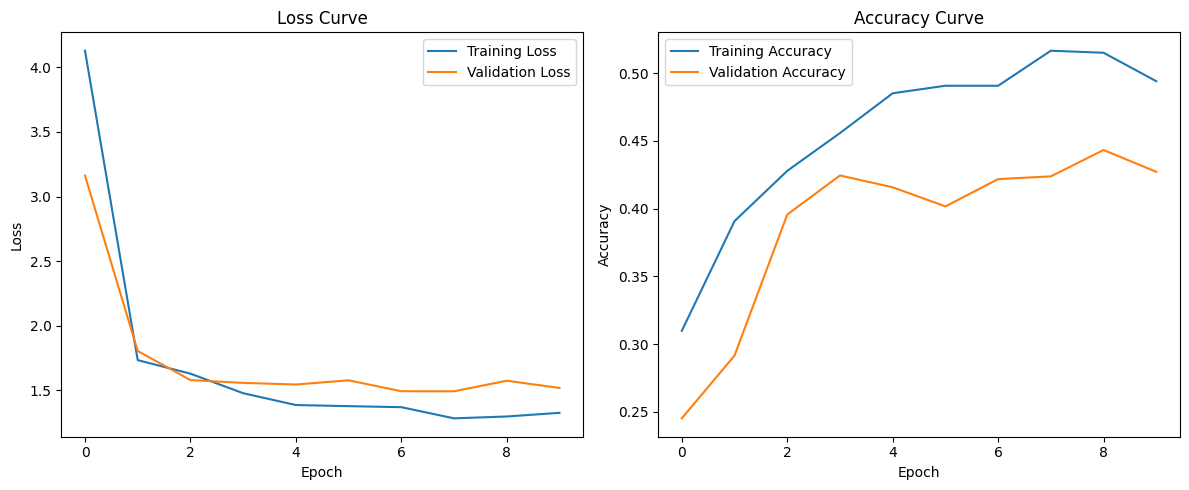

EmotionDetector(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (freq_pool): AdaptiveAvgPool2d(outpu

In [100]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, 
                num_epochs, lr, device='cuda'):
    """
    Train a CNN+LSTM model for emotion recognition with progress bars.

    Args:
        model: PyTorch nn.Module
        train_loader: DataLoader for training set
        val_loader: DataLoader for validation set
        num_epochs: number of epochs
        lr: learning rate
        device: 'cuda' or 'cpu'
    """
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with tqdm
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            train_loader_iter.set_postfix({'loss': running_loss/total, 'acc': correct/total})
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation loop with tqdm
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_loader_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for val_inputs, val_labels in val_loader_iter:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_outputs = model(val_inputs)
                v_loss = criterion(val_outputs, val_labels)
                
                val_loss += v_loss.item() * val_inputs.size(0)
                _, val_pred = val_outputs.max(1)
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)
                
                val_loader_iter.set_postfix({'val_loss': val_loss/val_total, 'val_acc': val_correct/val_total})
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Using device ", device)
m = EmotionDetector().to(device)
train_model(m, train_loader, val_loader, 
                num_epochs=10, lr=1e-3, device=device)

In [99]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
del m 

In [56]:
load = iter(train_loader)
feature, label = next(load)
print(feature.shape)

torch.Size([32, 1, 1025, 310])


In [75]:
c = 0
l = []
for name, param in m.named_parameters():
    c+=param.numel()
    l.append(param.numel())
l.sort()
print(l[len(l)//2])
print(l)
print(c)

18
[2, 4, 6, 8, 18, 72, 288, 1572864]
1573262


In [81]:
for name, param in m.named_parameters():
    print()
    print(name)
    print(param.flatten().cpu().median())
    print(param.flatten().cpu().std())


conv1.0.weight
tensor(0.0592, grad_fn=<MedianBackward0>)
tensor(0.1483, grad_fn=<StdBackward0>)

conv1.0.bias
tensor(-0.3799, grad_fn=<MedianBackward0>)
tensor(0.2572, grad_fn=<StdBackward0>)

conv2.0.weight
tensor(-0.0322, grad_fn=<MedianBackward0>)
tensor(0.1392, grad_fn=<StdBackward0>)

conv2.0.bias
tensor(-0.1715, grad_fn=<MedianBackward0>)
tensor(0.1821, grad_fn=<StdBackward0>)

conv3.0.weight
tensor(-0.0349, grad_fn=<MedianBackward0>)
tensor(0.1090, grad_fn=<StdBackward0>)

conv3.0.bias
tensor(-0.0573, grad_fn=<MedianBackward0>)
tensor(0.0832, grad_fn=<StdBackward0>)

fc1.weight
tensor(-8.1746e-05, grad_fn=<MedianBackward0>)
tensor(0.0212, grad_fn=<StdBackward0>)

fc1.bias
tensor(-0.0040, grad_fn=<MedianBackward0>)
tensor(0.0328, grad_fn=<StdBackward0>)
